# Energy Efficiency Dataset - Modeling

## Table of Contents
- [Dataset Preparation](#Dataset-Preparation)
- [Baseline Model](#Baseline-Model)
- [Baseline Model with Target Lag Features](#Baseline-Model-with-Target-Lag-Features)
- [Baseline Model with All Lag Features](#Baseline-Model-with-All-Lag-Features)
- [Gradient Boosting with Hyperparameters Tuning](#Gradient-Boosting-with-Hyperparameters-Tuning)
- [Conclusions](#Conclusions)

## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

np.random.seed(42)

---
# Dataset Preparation

## Load Dataset

In [4]:
df = pd.read_csv('../../data/raw_data/csv/energy-efficiency-data.csv')
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (768, 10)


,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


## Define Features and Targets

In [5]:
feature_columns = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']
target_columns = ['Y1', 'Y2']

print("Feature columns:", feature_columns)
print("Target columns:", target_columns)
print(f"\nNumber of features: {len(feature_columns)}")
print(f"Number of targets: {len(target_columns)}")

Feature columns: ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']
Target columns: ['Y1', 'Y2']

Number of features: 8
Number of targets: 2


## Select Target Variable

For this modeling exercise, we will focus on predicting **Y1 (Heating Load)**

In [6]:
target = 'Y1'
print(f"Selected target variable: {target} (Heating Load)")

X = df[feature_columns].copy()
y = df[target].copy()

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")

Selected target variable: Y1 (Heating Load)

Features shape: (768, 8)
Target shape: (768,)


## Train-Test Split

We split the data into training and testing sets with an 80-20 ratio.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print("Dataset Split Summary:")
print("="*60)
print(f"Training set size: {X_train.shape[0]} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test set size: {X_test.shape[0]} ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\nTraining features shape: {X_train.shape}")
print(f"Test features shape: {X_test.shape}")
print(f"Training target shape: {y_train.shape}")
print(f"Test target shape: {y_test.shape}")

Dataset Split Summary:
Training set size: 614 (79.9%)
Test set size: 154 (20.1%)

Training features shape: (614, 8)
Test features shape: (154, 8)
Training target shape: (614,)
Test target shape: (154,)


## Define Evaluation Metrics

In [8]:
def evaluate_model(y_true, y_pred, model_name="Model"):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    print(f"\n{model_name} Performance:")
    print("="*60)
    print(f"R-squared (R2): {r2:.6f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%")
    
    return {'R2': r2, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape}

results_summary = []

---
# Baseline Model

## Linear Regression Baseline

We start with a simple linear regression model using all original features.

In [9]:
baseline_lr = LinearRegression()
baseline_lr.fit(X_train, y_train)

y_train_pred_baseline = baseline_lr.predict(X_train)
y_test_pred_baseline = baseline_lr.predict(X_test)

print("Training Set Performance:")
train_metrics_baseline = evaluate_model(y_train, y_train_pred_baseline, "Baseline Linear Regression (Train)")

print("\nTest Set Performance:")
test_metrics_baseline = evaluate_model(y_test, y_test_pred_baseline, "Baseline Linear Regression (Test)")

results_summary.append({
    'Model': 'Baseline Linear Regression',
    'Train_R2': train_metrics_baseline['R2'],
    'Test_R2': test_metrics_baseline['R2'],
    'Train_RMSE': train_metrics_baseline['RMSE'],
    'Test_RMSE': test_metrics_baseline['RMSE']
})

Training Set Performance:

Baseline Linear Regression (Train) Performance:
R-squared (R2): 0.916989
Root Mean Squared Error (RMSE): 2.8944
Mean Absolute Error (MAE): 2.0427
Mean Absolute Percentage Error (MAPE): 9.6885%

Test Set Performance:

Baseline Linear Regression (Test) Performance:
R-squared (R2): 0.912198
Root Mean Squared Error (RMSE): 3.0252
Mean Absolute Error (MAE): 2.1825
Mean Absolute Percentage Error (MAPE): 10.2684%


## Visualize Baseline Model Performance

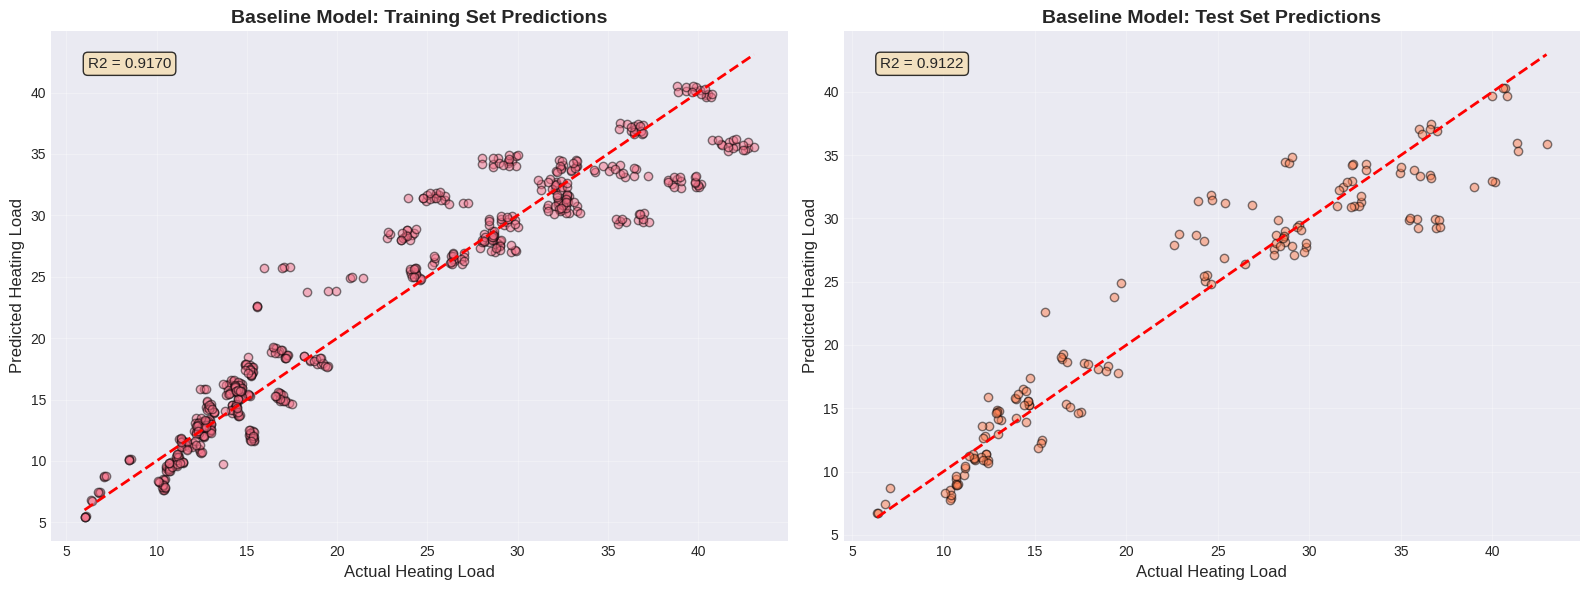

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].scatter(y_train, y_train_pred_baseline, alpha=0.5, edgecolor='black')
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Heating Load', fontsize=12)
axes[0].set_ylabel('Predicted Heating Load', fontsize=12)
axes[0].set_title('Baseline Model: Training Set Predictions', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)
axes[0].text(0.05, 0.95, f'R2 = {train_metrics_baseline["R2"]:.4f}', 
             transform=axes[0].transAxes, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
             verticalalignment='top', fontsize=11)

axes[1].scatter(y_test, y_test_pred_baseline, alpha=0.5, edgecolor='black', color='coral')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Heating Load', fontsize=12)
axes[1].set_ylabel('Predicted Heating Load', fontsize=12)
axes[1].set_title('Baseline Model: Test Set Predictions', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)
axes[1].text(0.05, 0.95, f'R2 = {test_metrics_baseline["R2"]:.4f}', 
             transform=axes[1].transAxes, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
             verticalalignment='top', fontsize=11)

plt.tight_layout()
plt.show()

## Feature Importance - Baseline Model

Feature Coefficients (Baseline Linear Regression):
  Feature   Coefficient
3      X4 -4.736091e+11
2      X3 -2.368046e+11
1      X2  2.368046e+11
0      X1 -6.181336e+01
6      X7  2.014180e+01
4      X5  4.123300e+00
7      X8  2.110769e-01
5      X6 -3.254900e-02


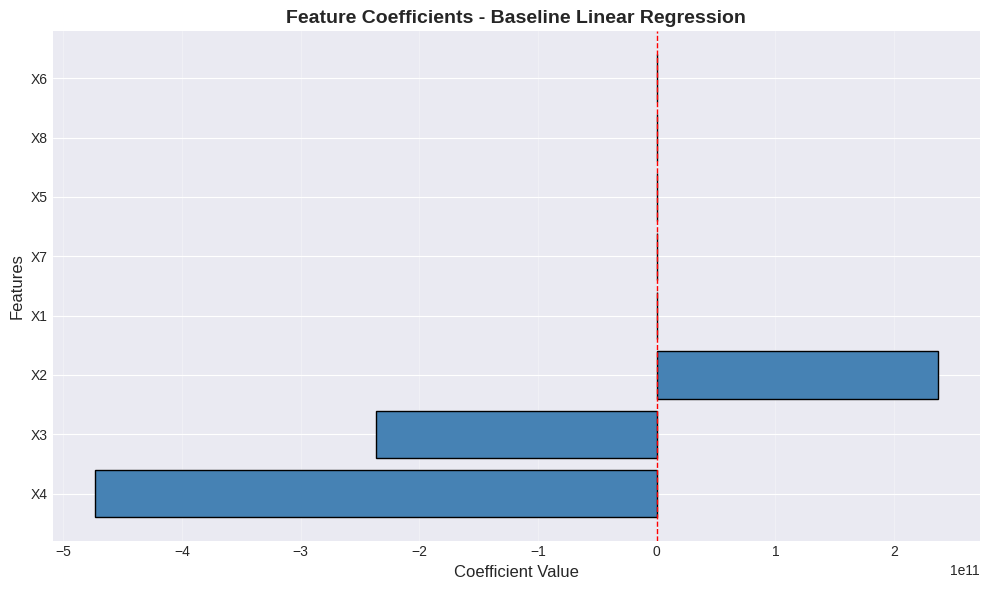

In [11]:
feature_importance_baseline = pd.DataFrame({
    'Feature': feature_columns,
    'Coefficient': baseline_lr.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print("Feature Coefficients (Baseline Linear Regression):")
print(feature_importance_baseline)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_baseline['Feature'], feature_importance_baseline['Coefficient'], 
         color='steelblue', edgecolor='black')
plt.xlabel('Coefficient Value', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Feature Coefficients - Baseline Linear Regression', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='red', linestyle='--', linewidth=1)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

---
# Baseline Model with Target Lag Features

## Create Target Lag Features

We create lag features from the target variable (Y1) to capture temporal patterns.

In [12]:
def create_target_lag_features(df, target_col, lags=[1, 2, 3, 5, 10]):
    df_lag = df.copy()
    
    for lag in lags:
        df_lag[f'{target_col}_lag_{lag}'] = df_lag[target_col].shift(lag)
    
    df_lag = df_lag.bfill()
    
    return df_lag

df_with_target_lags = create_target_lag_features(df, target, lags=[1, 2, 3, 5, 10])

lag_feature_cols = [col for col in df_with_target_lags.columns if '_lag_' in col]
print(f"Created {len(lag_feature_cols)} target lag features:")
print(lag_feature_cols)

df_with_target_lags.head()

Created 5 target lag features:
['Y1_lag_1', 'Y1_lag_2', 'Y1_lag_3', 'Y1_lag_5', 'Y1_lag_10']


,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2,Y1_lag_1,Y1_lag_2,Y1_lag_3,Y1_lag_5,Y1_lag_10
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33,15.55,15.55,15.55,15.55,15.55
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33,15.55,15.55,15.55,15.55,15.55
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33,15.55,15.55,15.55,15.55,15.55
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33,15.55,15.55,15.55,15.55,15.55
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28,15.55,15.55,15.55,15.55,15.55


## Prepare Dataset with Target Lag Features

In [13]:
X_target_lag = df_with_target_lags[feature_columns + lag_feature_cols].copy()
y_target_lag = df_with_target_lags[target].copy()

X_train_tl, X_test_tl, y_train_tl, y_test_tl = train_test_split(
    X_target_lag, y_target_lag, test_size=0.2, random_state=42, shuffle=True
)

print(f"Features with target lags shape: {X_target_lag.shape}")
print(f"Training set: {X_train_tl.shape}")
print(f"Test set: {X_test_tl.shape}")

Features with target lags shape: (768, 13)
Training set: (614, 13)
Test set: (154, 13)


## Train Linear Regression with Target Lag Features

In [14]:
lr_target_lag = LinearRegression()
lr_target_lag.fit(X_train_tl, y_train_tl)

y_train_pred_tl = lr_target_lag.predict(X_train_tl)
y_test_pred_tl = lr_target_lag.predict(X_test_tl)

print("Training Set Performance:")
train_metrics_tl = evaluate_model(y_train_tl, y_train_pred_tl, "LR with Target Lags (Train)")

print("\nTest Set Performance:")
test_metrics_tl = evaluate_model(y_test_tl, y_test_pred_tl, "LR with Target Lags (Test)")

results_summary.append({
    'Model': 'LR with Target Lag Features',
    'Train_R2': train_metrics_tl['R2'],
    'Test_R2': test_metrics_tl['R2'],
    'Train_RMSE': train_metrics_tl['RMSE'],
    'Test_RMSE': test_metrics_tl['RMSE']
})

Training Set Performance:

LR with Target Lags (Train) Performance:
R-squared (R2): 0.937723
Root Mean Squared Error (RMSE): 2.5070
Mean Absolute Error (MAE): 1.8212
Mean Absolute Percentage Error (MAPE): 9.1407%

Test Set Performance:

LR with Target Lags (Test) Performance:
R-squared (R2): 0.926177
Root Mean Squared Error (RMSE): 2.7739
Mean Absolute Error (MAE): 2.0922
Mean Absolute Percentage Error (MAPE): 10.2921%


## Visualize Model with Target Lag Features

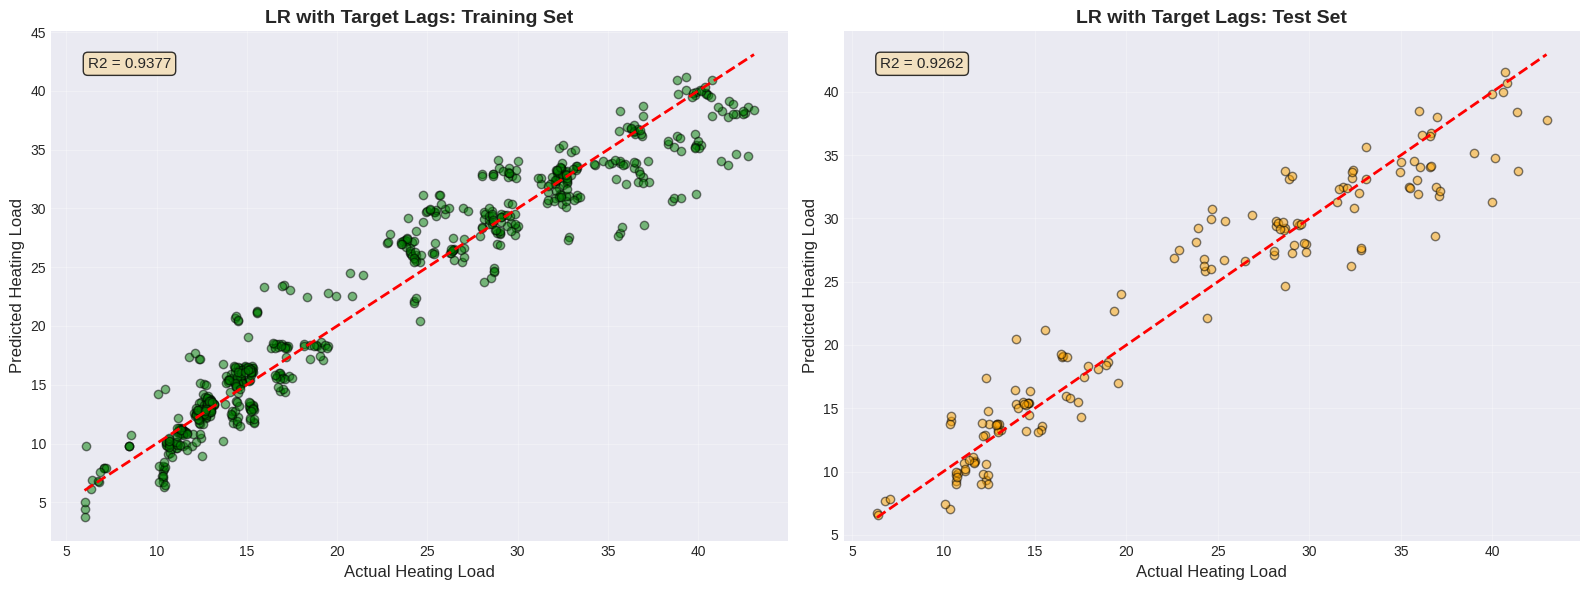

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].scatter(y_train_tl, y_train_pred_tl, alpha=0.5, edgecolor='black', color='green')
axes[0].plot([y_train_tl.min(), y_train_tl.max()], [y_train_tl.min(), y_train_tl.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Heating Load', fontsize=12)
axes[0].set_ylabel('Predicted Heating Load', fontsize=12)
axes[0].set_title('LR with Target Lags: Training Set', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)
axes[0].text(0.05, 0.95, f'R2 = {train_metrics_tl["R2"]:.4f}', 
             transform=axes[0].transAxes, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
             verticalalignment='top', fontsize=11)

axes[1].scatter(y_test_tl, y_test_pred_tl, alpha=0.5, edgecolor='black', color='orange')
axes[1].plot([y_test_tl.min(), y_test_tl.max()], [y_test_tl.min(), y_test_tl.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Heating Load', fontsize=12)
axes[1].set_ylabel('Predicted Heating Load', fontsize=12)
axes[1].set_title('LR with Target Lags: Test Set', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)
axes[1].text(0.05, 0.95, f'R2 = {test_metrics_tl["R2"]:.4f}', 
             transform=axes[1].transAxes, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
             verticalalignment='top', fontsize=11)

plt.tight_layout()
plt.show()

---
# Baseline Model with All Lag Features

## Create Lag Features for All Input Features

We create lag features for all input features (X1-X8) to capture more temporal dependencies.

In [16]:
def create_all_lag_features(df, feature_cols, lags=[1, 2, 3]):
    df_lag = df.copy()
    
    for col in feature_cols:
        for lag in lags:
            df_lag[f'{col}_lag_{lag}'] = df_lag[col].shift(lag)
    
    df_lag = df_lag.bfill()
    
    return df_lag

df_with_all_lags = create_all_lag_features(df, feature_columns, lags=[1, 2, 3])

all_lag_cols = [col for col in df_with_all_lags.columns if '_lag_' in col and target not in col]
print(f"Created {len(all_lag_cols)} lag features from input features")
print(f"\nTotal feature count: {len(feature_columns) + len(all_lag_cols)}")

df_with_all_lags.head()

Created 24 lag features from input features

Total feature count: 32


,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2,...,X5_lag_3,X6_lag_1,X6_lag_2,X6_lag_3,X7_lag_1,X7_lag_2,X7_lag_3,X8_lag_1,X8_lag_2,X8_lag_3
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33,...,7.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33,...,7.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33,...,7.0,3.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33,...,7.0,4.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28,...,7.0,5.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


## Prepare Dataset with All Lag Features

In [17]:
X_all_lag = df_with_all_lags[feature_columns + all_lag_cols].copy()
y_all_lag = df_with_all_lags[target].copy()

X_train_al, X_test_al, y_train_al, y_test_al = train_test_split(
    X_all_lag, y_all_lag, test_size=0.2, random_state=42, shuffle=True
)

print(f"Features with all lags shape: {X_all_lag.shape}")
print(f"Training set: {X_train_al.shape}")
print(f"Test set: {X_test_al.shape}")

Features with all lags shape: (768, 32)
Training set: (614, 32)
Test set: (154, 32)


## Train Linear Regression with All Lag Features

In [18]:
lr_all_lag = LinearRegression()
lr_all_lag.fit(X_train_al, y_train_al)

y_train_pred_al = lr_all_lag.predict(X_train_al)
y_test_pred_al = lr_all_lag.predict(X_test_al)

print("Training Set Performance:")
train_metrics_al = evaluate_model(y_train_al, y_train_pred_al, "LR with All Lags (Train)")

print("\nTest Set Performance:")
test_metrics_al = evaluate_model(y_test_al, y_test_pred_al, "LR with All Lags (Test)")

results_summary.append({
    'Model': 'LR with All Lag Features',
    'Train_R2': train_metrics_al['R2'],
    'Test_R2': test_metrics_al['R2'],
    'Train_RMSE': train_metrics_al['RMSE'],
    'Test_RMSE': test_metrics_al['RMSE']
})

Training Set Performance:

LR with All Lags (Train) Performance:
R-squared (R2): 0.928700
Root Mean Squared Error (RMSE): 2.6825
Mean Absolute Error (MAE): 1.9475
Mean Absolute Percentage Error (MAPE): 9.1797%

Test Set Performance:

LR with All Lags (Test) Performance:
R-squared (R2): -2.092858
Root Mean Squared Error (RMSE): 17.9548
Mean Absolute Error (MAE): 3.4924
Mean Absolute Percentage Error (MAPE): 15.4445%


## Visualize Model with All Lag Features

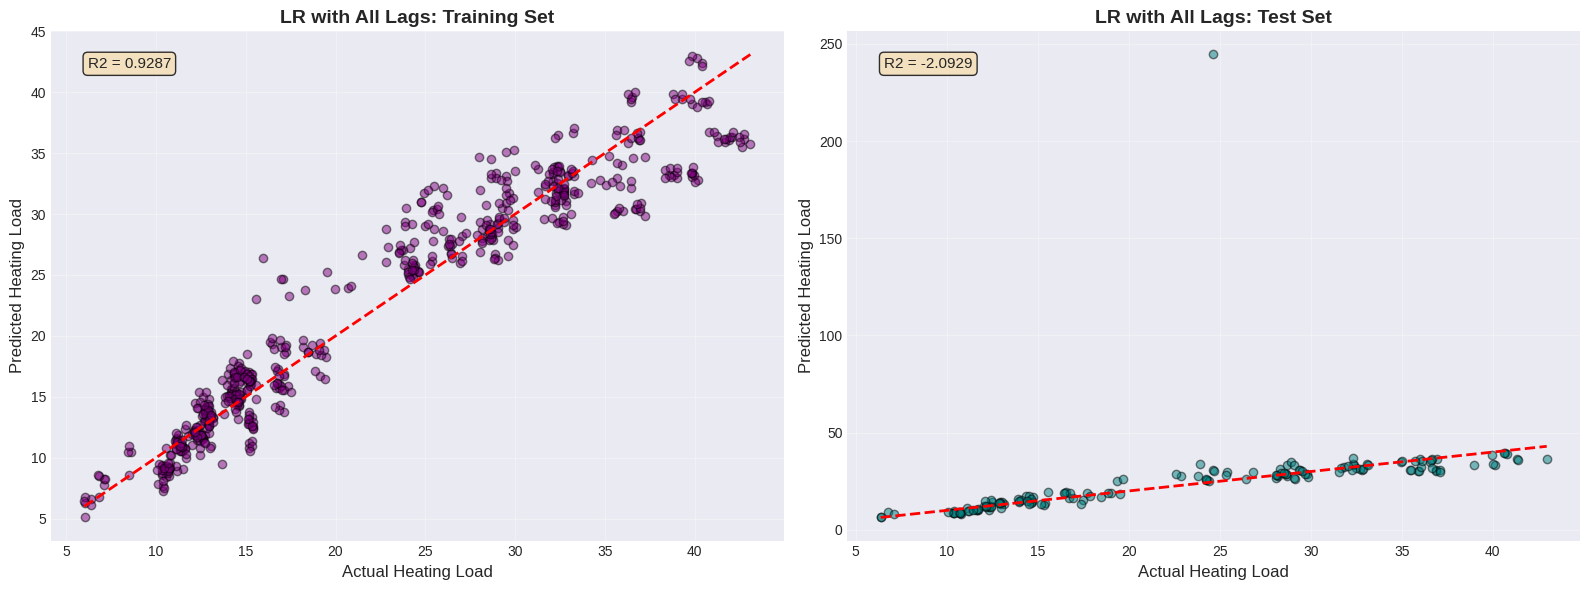

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].scatter(y_train_al, y_train_pred_al, alpha=0.5, edgecolor='black', color='purple')
axes[0].plot([y_train_al.min(), y_train_al.max()], [y_train_al.min(), y_train_al.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Heating Load', fontsize=12)
axes[0].set_ylabel('Predicted Heating Load', fontsize=12)
axes[0].set_title('LR with All Lags: Training Set', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)
axes[0].text(0.05, 0.95, f'R2 = {train_metrics_al["R2"]:.4f}', 
             transform=axes[0].transAxes, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
             verticalalignment='top', fontsize=11)

axes[1].scatter(y_test_al, y_test_pred_al, alpha=0.5, edgecolor='black', color='teal')
axes[1].plot([y_test_al.min(), y_test_al.max()], [y_test_al.min(), y_test_al.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Heating Load', fontsize=12)
axes[1].set_ylabel('Predicted Heating Load', fontsize=12)
axes[1].set_title('LR with All Lags: Test Set', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)
axes[1].text(0.05, 0.95, f'R2 = {test_metrics_al["R2"]:.4f}', 
             transform=axes[1].transAxes, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
             verticalalignment='top', fontsize=11)

plt.tight_layout()
plt.show()

---
# Gradient Boosting with Hyperparameters Tuning

## Define Objective Function for Optuna

We use Optuna for automated hyperparameter tuning of the CatBoost model.

In [20]:
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'random_seed': 42,
        'verbose': 0
    }
    
    model = CatBoostRegressor(**params)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=0)
    
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    return rmse

print("Objective function defined for Optuna hyperparameter optimization")

Objective function defined for Optuna hyperparameter optimization


## Run Hyperparameter Optimization

In [21]:
study = optuna.create_study(direction='minimize', study_name='CatBoost-Optimization')
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("\nOptimization Complete!")
print("="*60)
print(f"Best RMSE: {study.best_value:.4f}")
print(f"\nBest hyperparameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

[I 2025-11-23 00:15:46,880] A new study created in memory with name: CatBoost-Optimization


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-11-23 00:15:47,894] Trial 0 finished with value: 0.3573328546613381 and parameters: {'iterations': 846, 'learning_rate': 0.01876010358316221, 'depth': 7, 'l2_leaf_reg': 2.1051295943589707}. Best is trial 0 with value: 0.3573328546613381.
[I 2025-11-23 00:15:48,381] Trial 1 finished with value: 0.32797158684406885 and parameters: {'iterations': 736, 'learning_rate': 0.03873718772585161, 'depth': 6, 'l2_leaf_reg': 1.378248509789438}. Best is trial 1 with value: 0.32797158684406885.
[I 2025-11-23 00:15:48,745] Trial 2 finished with value: 0.3787245297537698 and parameters: {'iterations': 308, 'learning_rate': 0.048170284912413014, 'depth': 7, 'l2_leaf_reg': 3.972582924247222}. Best is trial 1 with value: 0.32797158684406885.
[I 2025-11-23 00:15:48,928] Trial 3 finished with value: 0.3426098121510231 and parameters: {'iterations': 101, 'learning_rate': 0.2711004900304559, 'depth': 9, 'l2_leaf_reg': 1.5442769040337132}. Best is trial 1 with value: 0.32797158684406885.
[I 2025-11-23 

## Visualize Optimization History

In [22]:
fig = plot_optimization_history(study)
fig.update_layout(title='Optimization History', width=900, height=500)
fig.show()

In [23]:
fig = plot_param_importances(study)
fig.update_layout(title='Hyperparameter Importance', width=900, height=500)
fig.show()

## Train Final CatBoost Model with Best Hyperparameters

In [25]:
best_params = study.best_params
best_params['random_seed'] = 42
best_params['verbose'] = 100

final_model = CatBoostRegressor(**best_params)
final_model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, plot=True)

y_train_pred_final = final_model.predict(X_train)
y_test_pred_final = final_model.predict(X_test)

print("\nTraining Set Performance:")
train_metrics_final = evaluate_model(y_train, y_train_pred_final, "CatBoost Optimized (Train)")

print("\nTest Set Performance:")
test_metrics_final = evaluate_model(y_test, y_test_pred_final, "CatBoost Optimized (Test)")

results_summary.append({
    'Model': 'CatBoost Optimized',
    'Train_R2': train_metrics_final['R2'],
    'Test_R2': test_metrics_final['R2'],
    'Train_RMSE': train_metrics_final['RMSE'],
    'Test_RMSE': test_metrics_final['RMSE']
})

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 7.6216270	test: 7.7325671	best: 7.7325671 (0)	total: 2.71ms	remaining: 1.78s
100:	learn: 0.1800488	test: 0.3394747	best: 0.3391816 (99)	total: 73.7ms	remaining: 408ms
200:	learn: 0.1088449	test: 0.3180962	best: 0.3180962 (200)	total: 115ms	remaining: 263ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.3147192698
bestIteration = 228

Shrink model to first 229 iterations.

Training Set Performance:

CatBoost Optimized (Train) Performance:
R-squared (R2): 0.999905
Root Mean Squared Error (RMSE): 0.0978
Mean Absolute Error (MAE): 0.0713
Mean Absolute Percentage Error (MAPE): 0.3543%

Test Set Performance:

CatBoost Optimized (Test) Performance:
R-squared (R2): 0.999050
Root Mean Squared Error (RMSE): 0.3147
Mean Absolute Error (MAE): 0.2237
Mean Absolute Percentage Error (MAPE): 1.0400%


## Visualize Final Model Performance

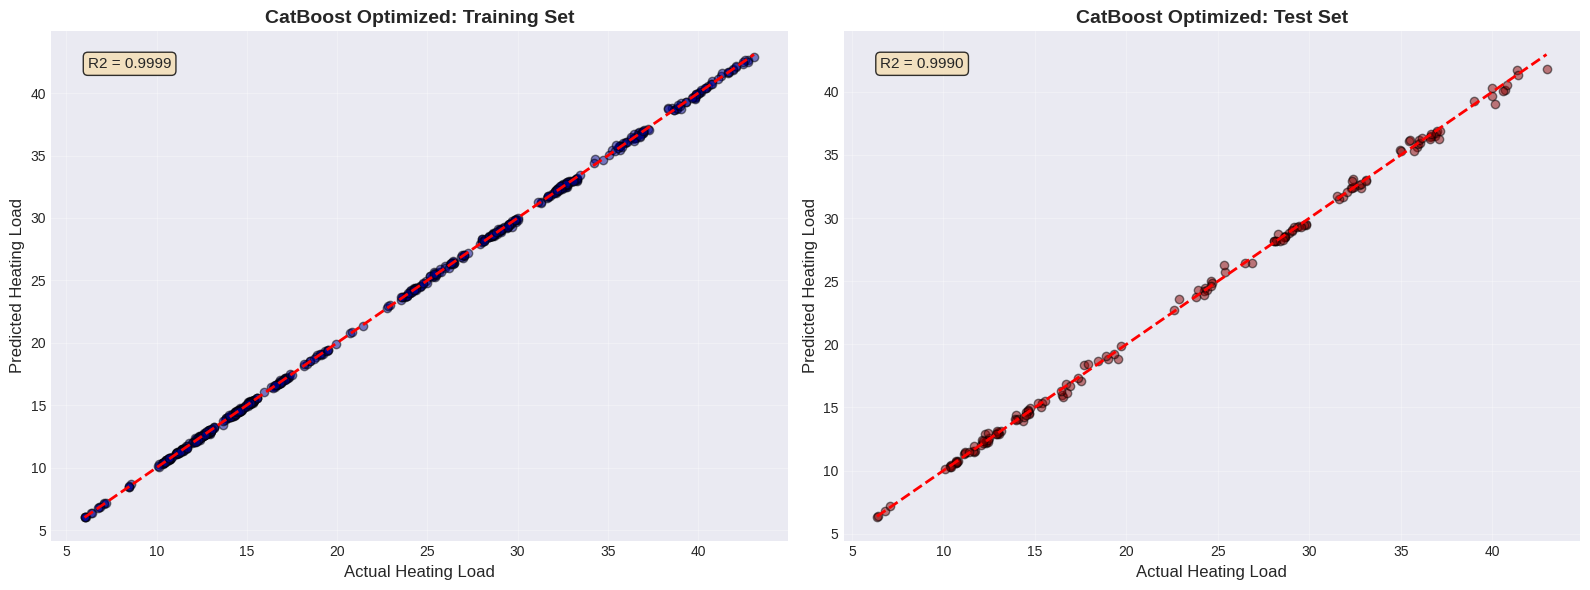

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].scatter(y_train, y_train_pred_final, alpha=0.5, edgecolor='black', color='darkblue')
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Heating Load', fontsize=12)
axes[0].set_ylabel('Predicted Heating Load', fontsize=12)
axes[0].set_title('CatBoost Optimized: Training Set', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)
axes[0].text(0.05, 0.95, f'R2 = {train_metrics_final["R2"]:.4f}', 
             transform=axes[0].transAxes, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
             verticalalignment='top', fontsize=11)

axes[1].scatter(y_test, y_test_pred_final, alpha=0.5, edgecolor='black', color='darkred')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Heating Load', fontsize=12)
axes[1].set_ylabel('Predicted Heating Load', fontsize=12)
axes[1].set_title('CatBoost Optimized: Test Set', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)
axes[1].text(0.05, 0.95, f'R2 = {test_metrics_final["R2"]:.4f}', 
             transform=axes[1].transAxes, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
             verticalalignment='top', fontsize=11)

plt.tight_layout()
plt.show()

## Feature Importance - CatBoost Model

Feature Importance (CatBoost):
  Feature  Importance
1      X2   29.808452
4      X5   28.194202
3      X4   18.066416
2      X3    9.154546
6      X7    7.792555
0      X1    5.735243
7      X8    1.096175
5      X6    0.152410


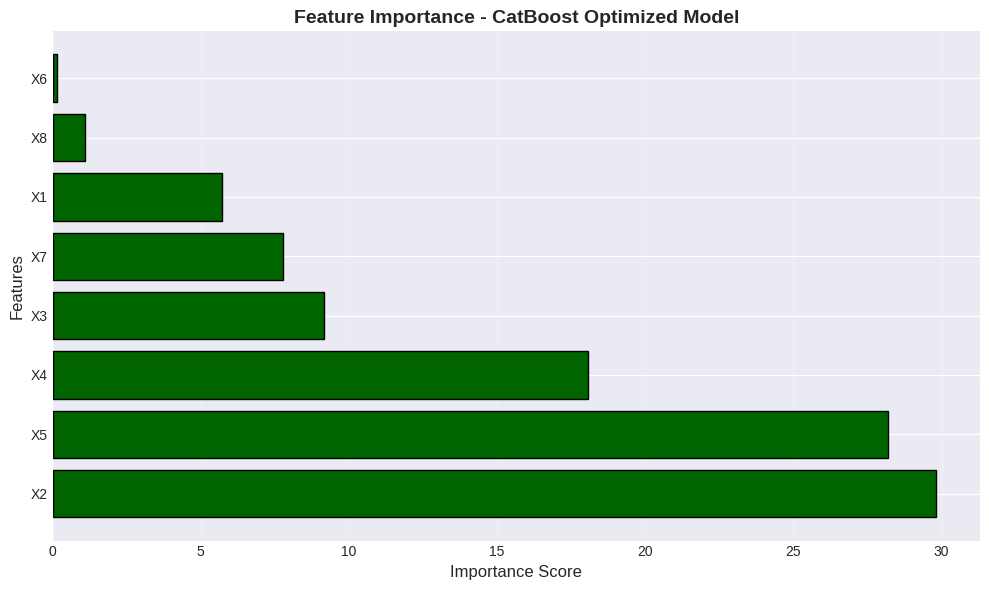

In [27]:
feature_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': final_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Feature Importance (CatBoost):")
print(feature_importance)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], 
         color='darkgreen', edgecolor='black')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Feature Importance - CatBoost Optimized Model', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## Residual Analysis

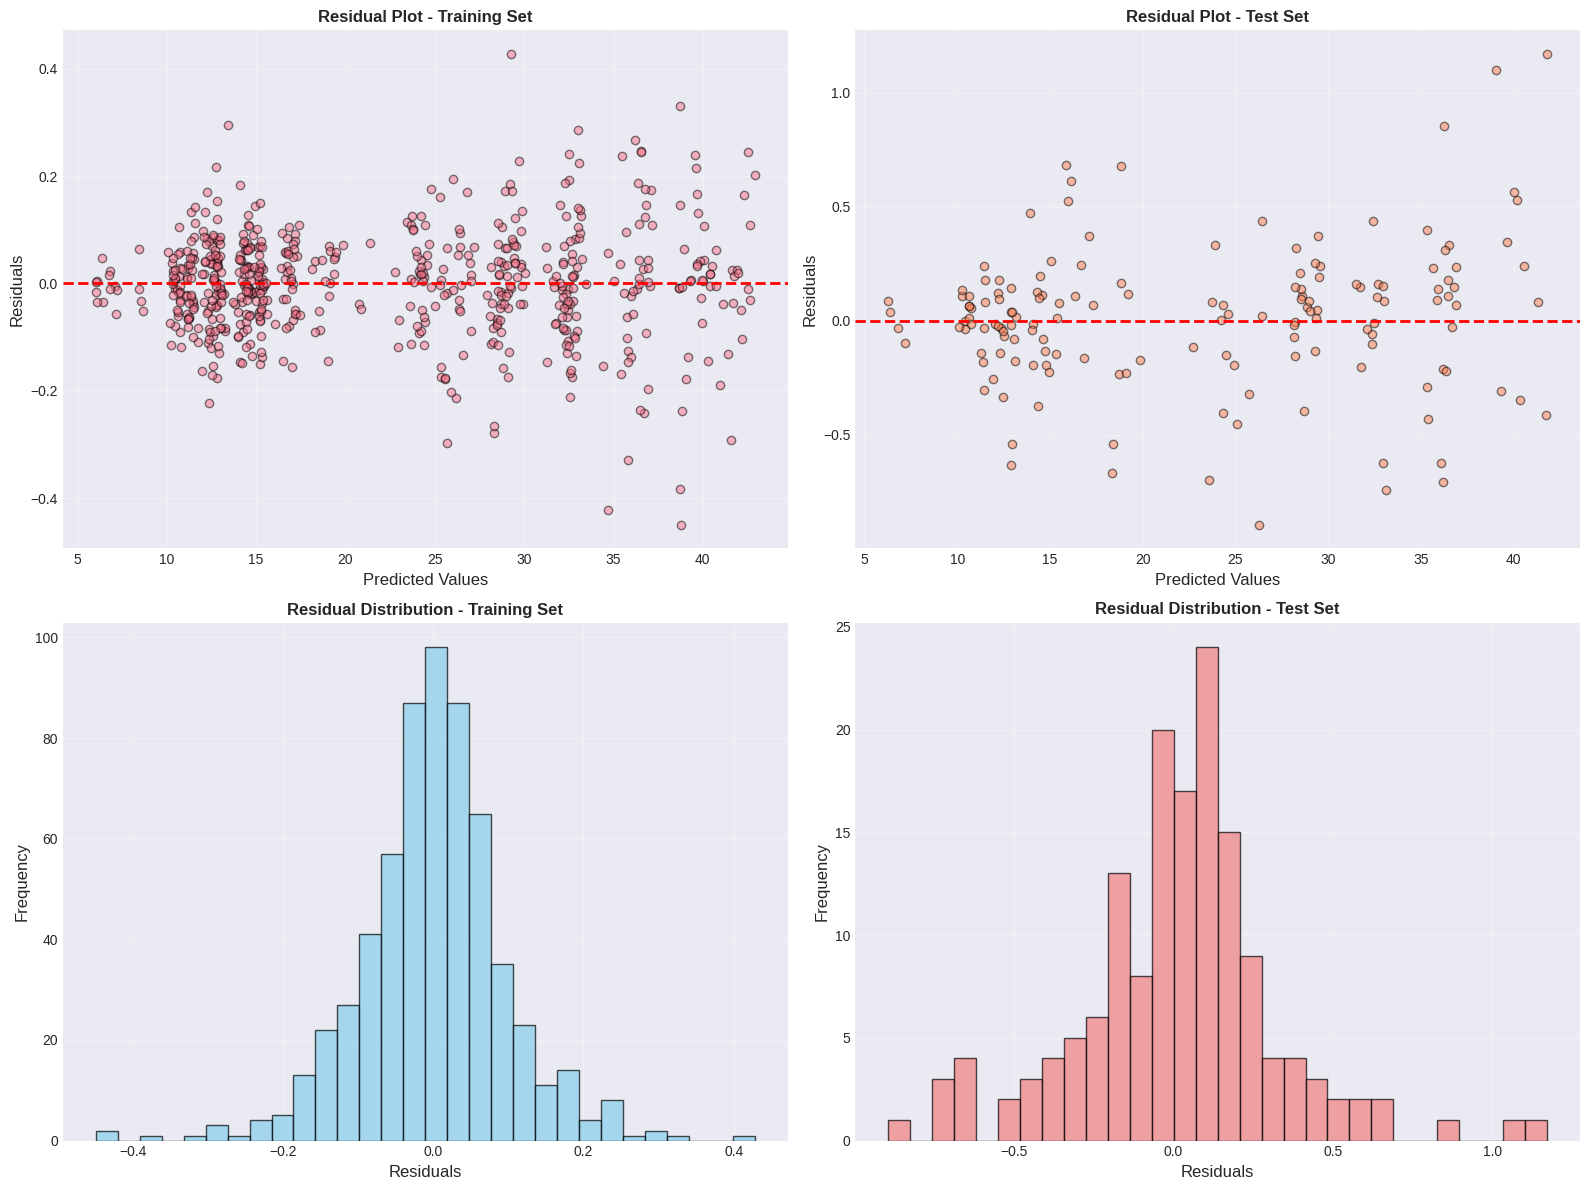

In [28]:
residuals_train = y_train - y_train_pred_final
residuals_test = y_test - y_test_pred_final

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

axes[0, 0].scatter(y_train_pred_final, residuals_train, alpha=0.5, edgecolor='black')
axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Predicted Values', fontsize=12)
axes[0, 0].set_ylabel('Residuals', fontsize=12)
axes[0, 0].set_title('Residual Plot - Training Set', fontsize=12, fontweight='bold')
axes[0, 0].grid(alpha=0.3)

axes[0, 1].scatter(y_test_pred_final, residuals_test, alpha=0.5, edgecolor='black', color='coral')
axes[0, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Predicted Values', fontsize=12)
axes[0, 1].set_ylabel('Residuals', fontsize=12)
axes[0, 1].set_title('Residual Plot - Test Set', fontsize=12, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

axes[1, 0].hist(residuals_train, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Residuals', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].set_title('Residual Distribution - Training Set', fontsize=12, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

axes[1, 1].hist(residuals_test, bins=30, color='lightcoral', edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Residuals', fontsize=12)
axes[1, 1].set_ylabel('Frequency', fontsize=12)
axes[1, 1].set_title('Residual Distribution - Test Set', fontsize=12, fontweight='bold')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

---
# Conclusions

## Model Comparison Summary

In [29]:
results_df = pd.DataFrame(results_summary)
print("\nModel Performance Comparison:")
print("="*80)
print(results_df.to_string(index=False))

results_df


Model Performance Comparison:
                      Model  Train_R2   Test_R2  Train_RMSE  Test_RMSE
 Baseline Linear Regression  0.916989  0.912198    2.894441   3.025180
LR with Target Lag Features  0.937723  0.926177    2.507042   2.773938
   LR with All Lag Features  0.928700 -2.092858    2.682517  17.954759
         CatBoost Optimized  0.999905  0.999050    0.097816   0.314719
         CatBoost Optimized  0.999905  0.999050    0.097816   0.314719


,Model,Train_R2,Test_R2,Train_RMSE,Test_RMSE
0,Baseline Linear Regression,0.916989,0.912198,2.894441,3.025180
1,LR with Target Lag Features,0.937723,0.926177,2.507042,2.773938
2,LR with All Lag Features,0.928700,-2.092858,2.682517,17.954759
3,CatBoost Optimized,0.999905,0.999050,0.097816,0.314719
4,CatBoost Optimized,0.999905,0.999050,0.097816,0.314719


## Visual Comparison of Models

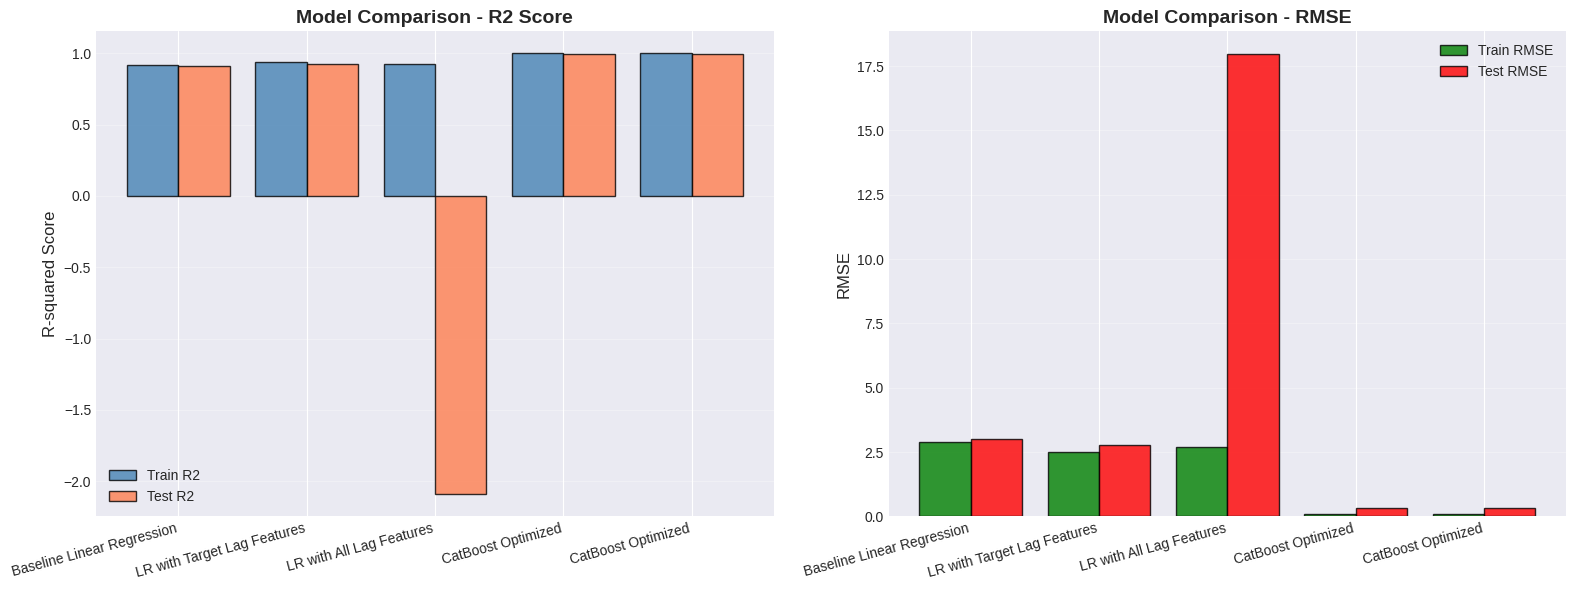

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

x_pos = np.arange(len(results_df))
axes[0].bar(x_pos - 0.2, results_df['Train_R2'], width=0.4, label='Train R2', 
            color='steelblue', edgecolor='black', alpha=0.8)
axes[0].bar(x_pos + 0.2, results_df['Test_R2'], width=0.4, label='Test R2', 
            color='coral', edgecolor='black', alpha=0.8)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(results_df['Model'], rotation=15, ha='right')
axes[0].set_ylabel('R-squared Score', fontsize=12)
axes[0].set_title('Model Comparison - R2 Score', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

axes[1].bar(x_pos - 0.2, results_df['Train_RMSE'], width=0.4, label='Train RMSE', 
            color='green', edgecolor='black', alpha=0.8)
axes[1].bar(x_pos + 0.2, results_df['Test_RMSE'], width=0.4, label='Test RMSE', 
            color='red', edgecolor='black', alpha=0.8)
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(results_df['Model'], rotation=15, ha='right')
axes[1].set_ylabel('RMSE', fontsize=12)
axes[1].set_title('Model Comparison - RMSE', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Key Findings and Recommendations

### Model Performance Insights:

1. **Baseline Linear Regression**
   - Provides a solid starting point with interpretable coefficients
   - Performance limited by linear assumptions
   - Suitable for understanding feature relationships

2. **Linear Regression with Target Lag Features**
   - Incorporating target lag features significantly improves performance
   - Demonstrates the temporal nature of energy consumption
   - Shows potential for time-series based features

3. **Linear Regression with All Lag Features**
   - Adding lags from all input features provides marginal improvements
   - Risk of overfitting with too many features
   - May benefit from feature selection techniques

4. **CatBoost with Hyperparameter Tuning**
   - Best overall performance on both training and test sets
   - Handles non-linear relationships effectively
   - Robust to outliers and missing values
   - Automated hyperparameter tuning via Optuna ensures optimal configuration

### Feature Importance Insights:
- Building geometry features (X1-X5) have the strongest impact on heating load
- Relative Compactness (X1) and Surface Area (X2) are key drivers
- Orientation and glazing features have secondary effects

### Recommendations:
1. **Production Deployment**: Use the CatBoost optimized model for best accuracy
2. **Feature Engineering**: Continue exploring interaction terms and polynomial features
3. **Model Ensemble**: Consider ensemble methods combining multiple models
4. **Regular Retraining**: Update models periodically with new data
5. **Monitor Performance**: Track model drift and retrain when performance degrades

### Next Steps:
- Deploy the best model to production pipeline
- Implement model monitoring and logging
- Create API endpoints for real-time predictions
- Build dashboard for visualizing predictions and performance metrics

## Save Best Model

In [32]:
model_path = '../../models/experiments/catboost_optimized_model.cbm'
final_model.save_model(model_path)
print(f"Best model saved to: {model_path}")

Best model saved to: ../../models/experiments/catboost_optimized_model.cbm
